# Insurance expenses prediction

The main goal of this notebook is to present a normal workflow of a regression problem. We will present first a
exploratory data analyis (EDA), then we will use some out-of-the-box results, follow by the use of pipelines to improve
the estimation, and at the end give the final conclussions. In this notebook is explore how to fit multiple ML models
to try to predict the policy holder insurance charges. The data was generated by of
[Brett Lantz](https://www.linkedin.com/in/brettlantz/) base on the U.S. Census Bureau database.

In particular, this notebook presents
* <b>EDA</b>: Exploratory Data Analysis to understand the problem.
* <b>Pipeline and Cross validation fitting</b>: We compare the results of an out-of-the-box fitting of the models:
    * <b>Lineal regression</b>
    * <b>Lasso</b>
    * <b>Ridge</b>
    * <b>Random Forest</b>
    * <b>XGBoost</b>
* <b>Random Search</b>: we further explore the `random forest` and `XGBoost` models, using a `random search` for their
parameters
* <b>Neural Networks with Cross-Validation</b>: We further compare the results of the models against a `neural network`.
* <b>Conclusions<b>


This type of analysis are useful for insurance companies since they help to narrow the policy holder's costs and
increase revenue to the company. In general, an insurance company needs to collect more in yearly premiums than it
spends on medical care to its beneficiaries. As a result, insurers invest a great deal of time and money to develop
models that accurately forecast medical expenses.

The main goal of this analysis is to use patient information to estimate the medical care expenses that could happen in
the duration of the contract. Moreover, the estimators could be used to create actuarial tables that are also mandatory
under the Solvency II framework.

**The Docker image for this notebook could be dowloaded from** [here](https://github.com/kaggle/docker-python).

<center> <img src="https://www.rushortho.com/sites/default/files/2016-10/AdobeStock_96790805.jpeg" alt="drawing" width="500"/> <center>

In [49]:
# General computation modules
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp # to simulate uniform(0,1)
import time
import datetime

import statsmodels
import os

# Data transformation modules
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Machine Learning modules
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestRegressor
# import xgboost as xgb
from xgboost.sklearn import XGBRegressor




## Exploratory Data Analysis

In order predict the charges of a policyholder, we have the following features to train our models:

* <b>age</b>: Age of primary beneficiary.
* <b>sex</b>: Insurance contractor gender, female, male.
* <b>bmi</b>: Body mass index, providing an understanding of body, weights that are relatively high or low relative to
height.
* <b>children</b>: Number of children covered by health insurance / Number of dependents.
* <b>smoker</b>: Smoking yes/no.
* <b>region</b>: The beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
* <b>charges</b>: Individual medical costs billed by health insurance.

Let us see the first five rows of information.

In [3]:
df = pd.read_csv("input/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Let us now take a look at the data types of each column; this will be very important to define each feature
transformation that will be the imput of our ML models.Also, let us notice that the data does not has any missing value.

In [223]:
df.info() # Also we could use 'df.isnull().sum()'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In the next cells we present some insides about the data. In particular, we notice that
* <b>No remarkable outlier</b>: it seems that the population has not any outlier since the ranges of values does not
present any weird behaviour.
* <b>Smoking plays an important factor in the charges</b>: There is a remarkable change in the distribution of smokers vr
no-smokers. This could be witness in the violin graphs of `charges` vr `sex` filtered by `smoke`. Higher charges are
presented in the smoker population. This is also shown by the plot of `charges` vr `smoke` by fitting a logistic
regression; we could predict that the person is an smoker by only considering that has a big charge in its insurance!
* <b>Women present more variation in their charges</b>: There is a noticeable difference between the charges of male and
female in terms of their variance.
* <b>Older population with higher charges</b>: By plotting the `charges` vr `age` we could see an increase as the person
is older.
* <b>No apparent difference in charges between regions</b>: by plotting `region` vr `charges` as a violin graph, we
do not see any remarkable difference between region's charges.

Let us present each 

In [27]:
df.describe() # Also we could use 'df.isnull().sum()'

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Let us separate the data into train and test sets.

/Users/arrigocoen/Dropbox/GitHub/2021 Repos/RNN/Enviroments/Python3_9_Mac/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


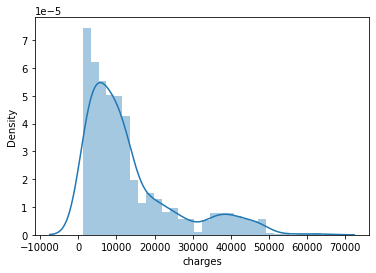

In [25]:
sns.distplot(df['charges'])

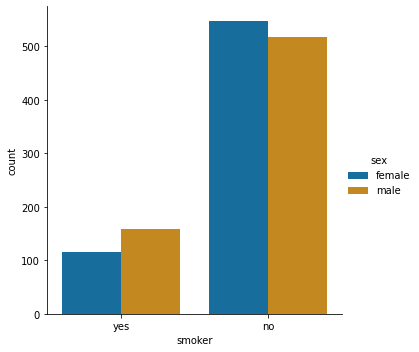

In [22]:
my_palette = ['colorblind', 'deep', 'pink', 'magma'][0]
sns.catplot(x="smoker", kind="count",hue = 'sex', palette=my_palette, data=df)

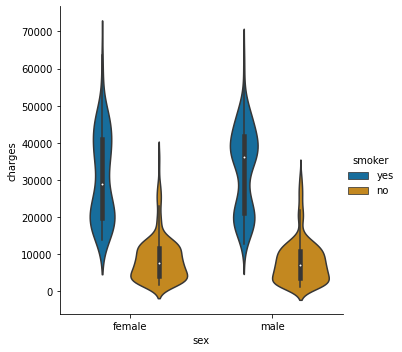

In [21]:
my_palette = ['colorblind', 'deep', 'pink', 'magma'][0]

sns.catplot(x="sex", y="charges", hue="smoker",
            kind="violin", data=df, palette = my_palette)


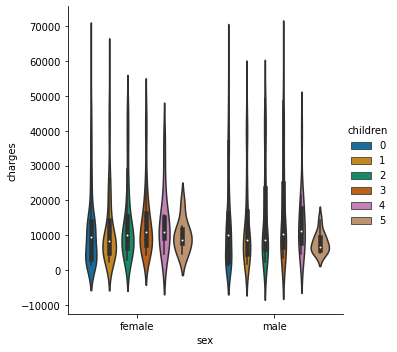

In [28]:
sns.catplot(x="sex", y="charges", hue="children",
            kind="violin", data=df, palette = my_palette)


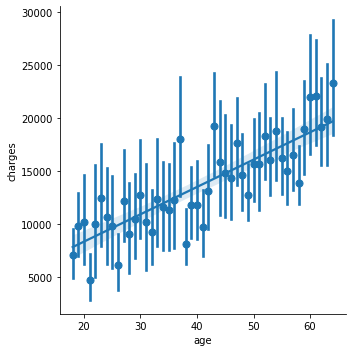

In [29]:
sns.lmplot(x="age", y="charges", data=df, x_estimator=np.mean)


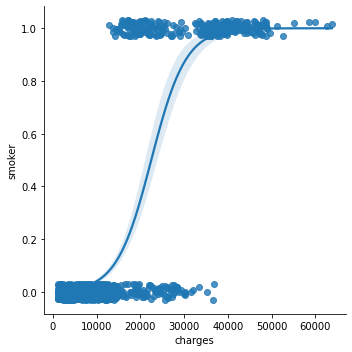

In [39]:

df_numeric = df.copy()

df_numeric['smoker'] = df_numeric.smoker.replace(to_replace=['no', 'yes'], value=[0, 1])
df_numeric
sns.lmplot(x="charges", y="smoker",
           y_jitter=.03,
           logistic=True,
           data=df_numeric)

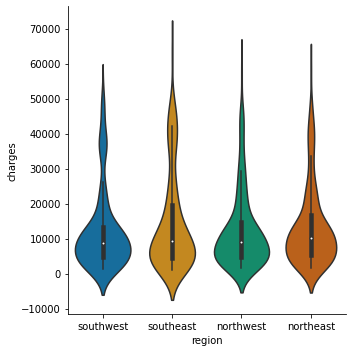

In [41]:
sns.catplot(x="region", y="charges", # hue="children",
            kind="violin", data=df, palette = my_palette)

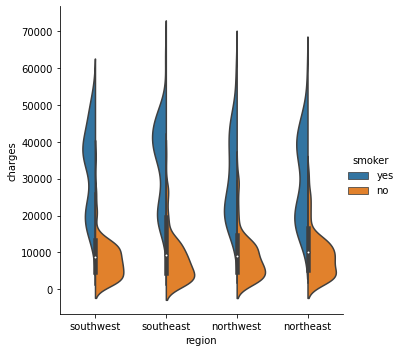

In [42]:
sns.catplot(x="region", y="charges",
            hue="smoker", # Grouping variable that will produce elements with different colors.
            kind="violin", # Options are: "point", "bar", "strip", "swarm", "box", "violin", or "boxen"
            split=True,
            data=df)



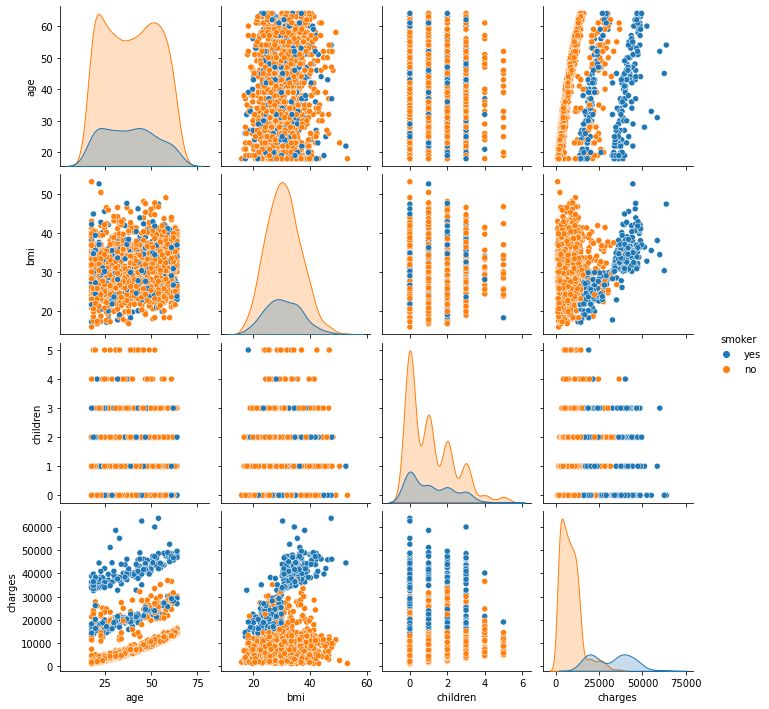

In [43]:
sns.pairplot(hue="smoker", # Grouping variable that will produce elements with different colors.
             data=df)


In [ ]:
df.plot(x="sex", y=['rmse_mean', 'rmse_std', 'mae_mean', 'mae_std'], kind="bar")
# plt.ylim([0,2])

In [7]:
X = df.drop('charges', axis=1)
y = df.charges

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

By observing the data types of each column, we will use the next column transformer.

In [5]:
column_trans = make_column_transformer(
    (OneHotEncoder(), ['sex', 'smoker', 'region']),
    (StandardScaler(), ['age', 'bmi', 'children']),
    remainder='passthrough')

In [51]:

c_scores = cross_validate(pipe, X_train, y_train, cv=5,scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'])
c_scores

## Methodology

Let us now continue with some out-of-the-box model to define a baseline of predictions. In particular, we will fit the
models `LinearRegression`, `Lasso` , `Ridge` `RandomForestRegressor`, and `XGBRegressor`

LinearRegression


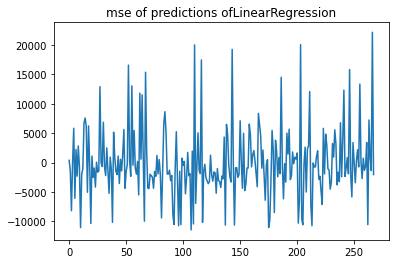

Lasso


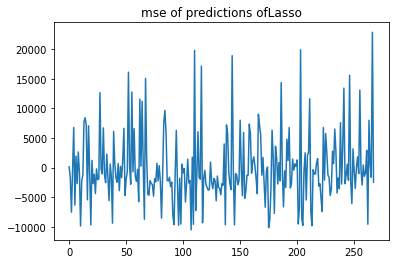

Ridge


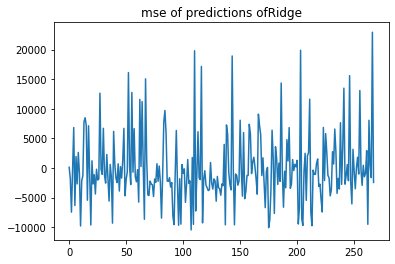

RandomForestRegressor


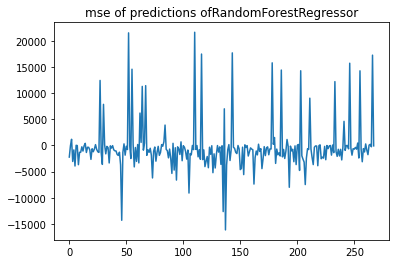

XGBRegressor


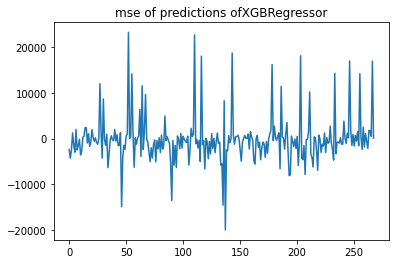

,model,rmse_mean,rmse_std,mae_mean,mae_std
0,LinearRegression,6155.112802,4.956161e+06,64.995007,265.229978
1,Lasso,6146.783657,5.028188e+06,65.126862,244.462377
2,Ridge,6146.993987,5.004419e+06,65.168117,243.363537
3,RandomForestRegressor,4887.590454,4.560856e+06,52.432015,175.509371
4,XGBRegressor,5334.370597,6.093790e+06,56.076843,304.273546


In [188]:
def model_results(model, results_df, model_name=None, verbose=0):
    """
    Given a model this function updats the dataframe results_df with the model's cross-validation (CV) results. This
    function also plots the errors with respect to the X_test and y_test sets.
    :param model: a machine learning model; eg. LinearRegression()
    :param results_df: a pd.DataFrame with the current CV information of the models
    :param model_name: an extra string with the name that will be use the information of the model. This variables
    is useful in case of having different instances of the model with different parameters. In case of None, it
    uses type(model).__name__
    :return: an update version of results_df with the `model`'s information
    """
    # Name of the model
    if model_name is None:
        model_name = type(model).__name__
    print(model_name)
    # Pipeline to do a cross validation
    pipe = make_pipeline(column_trans, model)
    # Results of the CV
    c_scores = cross_validate(pipe, X_train, y_train, cv=5,
                              scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
                              verbose=verbose, n_jobs=-1)
    # Extracting CV results
    mse_mean = np.sqrt(np.array(-c_scores['test_neg_mean_squared_error'])).mean()
    mse_std = c_scores['test_neg_mean_squared_error'].std()
    mae_mean =  np.sqrt(np.array(-c_scores['test_neg_mean_absolute_error'])).mean()
    mae_std = c_scores['test_neg_mean_absolute_error'].std()    
    fit_time_mean = c_scores['fit_time'].mean()
    # We define the new row of results_df
    new_row = [model_name, mse_mean, mse_std, mae_mean, mae_std]
    # Plot of predictions
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    plt.plot(np.array(y_test)-y_pred)
    plt.title("mse of predictions of"+model_name)
    plt.show()
    # This if take cares of the case when resuls_df is empty
    if results_df.iloc[0,0]== 0:
        results_df.loc[0] = new_row
    else:
        results_df.loc[len(results_df.index)] = new_row
    return results_df

def normalized_bar_plot(results_df):
    normalized_df = results_df.copy()
    normalized_df.iloc[:,1:]=(results_df.iloc[:,1:].copy())/results_df.iloc[:,1:].max()
    normalized_df.plot(x="model", y=['rmse_mean', 'rmse_std', 'mae_mean', 'mae_std'], kind="bar")
    # plt.ylim([0,2])
    plt.title("Equivalent magnitudes of results")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

col_results = ['model', 'rmse_mean', 'rmse_std', 'mae_mean', 'mae_std']
models = [LinearRegression(), Lasso(), Ridge(), RandomForestRegressor(), XGBRegressor()]
# models = [LinearRegression(), Lasso(), Ridge()]
results_df = pd.DataFrame(np.zeros([1,len(col_results)]), columns=col_results)

for i, model in enumerate(models):
    results_df = model_results(model, results_df)


results_df


Let us plot an scaled version of the `results_df` to compare graphically the models. For scaled version we mean that we
use `MinMaxScaler` to scale each of the numeric columns of `results_df`.

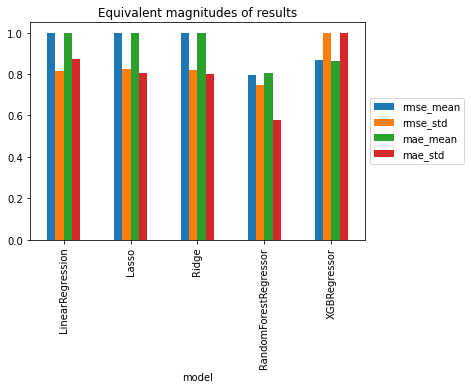

In [189]:
normalized_bar_plot(results_df)

We can see that the best out-of-the-box models were the `RandomForestRegressor()` and `XGBRegressor()`. Accordingly, in
the next sections we will fine tune these two models using `GridSearchCV` to find the parameters and `Pipeline` to
control the workflow.

These out-of-the-box results tell us that a good candidates for continue our estimation are the Random Forest and the XGBoost algorithms. We could notice that the mean

In [ ]:
# RandomForestRegressor
# mean error= 21899438.30561661 std error= 4728131.56890985
# rmse test =  4679.683568962394
# mae test =  2433.500512512784

In [ ]:
model = XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)

parameters = {
    'num_boost_round': [10, 25, 50],
    'eta': [0.05, 0.1, 0.3],
    'max_depth': [3, 4, 5],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.9, 1.0],
}

pipe = make_pipeline(column_trans,StandardScaler(), model)
c_scores = cross_val_score(pipe, X, y, cv=5,scoring='neg_mean_squared_error')
print("mean error=",-c_scores.mean(), "std error=",c_scores.std())

In [ ]:
model = linear_model.Lasso()
pipe = make_pipeline(column_trans,StandardScaler(),PolynomialFeatures(degree=4),StandardScaler(), model)
print(cross_val_score(pipe, X, y, cv=5).mean())

In [ ]:
# define the pipeline
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(degree=3, include_bias=False)),
    ('estimator', Ridge(alpha=1))
])

# Randomized Search CV for Random Forest

How to tune a pipeline in this [link](https://github.com/justmarkham/scikit-learn-tips/blob/master/notebooks/49_tune_multiple_models.ipynb)

In [72]:
# each of these models will take a turn as the second Pipeline step
model_1 = RandomForestRegressor()

model_2 = LinearRegression()

ct = make_pipeline(column_trans,StandardScaler())

# create the Pipeline
pipe = Pipeline([('preprocessor', ct), ('model', model_1)])

params1 = {}
params1['model__bootstrap'] = [True, False]
params1['model__max_depth'] = [70, 80, 90, 100, 110]
params1['model__max_features'] = [2, 3, 4, 6, 10]
params1['model__min_samples_leaf'] = [2, 3, 4, 5, 6]
params1['model__min_samples_split'] = [5, 8, 10, 12]
params1['model__n_estimators'] = [200, 300, 500, 1000]
params1['model'] = [model_1]

params2 = {}
params2['model'] = [model_2]

# create a list of parameter dictionaries
# params = [params1, params2]

params = [params1]

grid_RF = RandomizedSearchCV(pipe, params, n_jobs=-1, n_iter=20, verbose=1, cv=3, scoring='neg_mean_squared_error',
                             random_state = 42)
grid_RF.fit(X_train, y_train)
grid_RF.best_params_


Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'model__n_estimators': 1000,
 'model__min_samples_split': 8,
 'model__min_samples_leaf': 5,
 'model__max_features': 6,
 'model__max_depth': 90,
 'model__bootstrap': True,
 'model': RandomForestRegressor(max_depth=90, max_features=6, min_samples_leaf=5,
                       min_samples_split=8, n_estimators=1000)}

RandomForestRegressor_Tuned


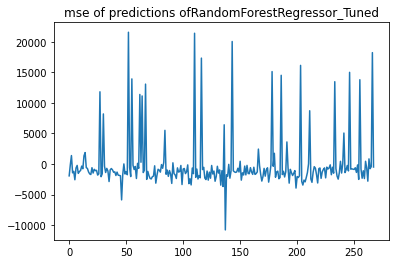

,model,rmse_mean,rmse_std,mae_mean,mae_std
0,LinearRegression,6155.112802,4.956161e+06,64.995007,265.229978
1,Lasso,6146.783657,5.028188e+06,65.126862,244.462377
2,Ridge,6146.993987,5.004419e+06,65.168117,243.363537
3,RandomForestRegressor,4887.590454,4.560856e+06,52.432015,175.509371
4,XGBRegressor,5334.370597,6.093790e+06,56.076843,304.273546
5,RandomForestRegressor_Tuned,4606.075065,4.614830e+06,51.092356,154.667537


In [190]:

model = grid_RF.best_params_['model']

results_df = model_results(model, results_df, model_name = 'RandomForestRegressor_Tuned')
results_df

We notice an improvement of the random forest model after tuning it. So, it continues being our best model.

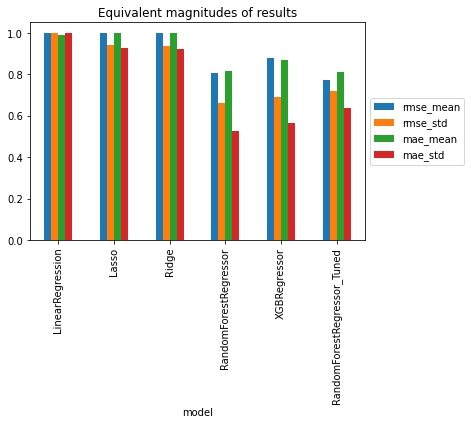

In [59]:
normalized_bar_plot(results_df)

In [ ]:
# model__n_estimators': 100,
#  'model__min_samples_split': 8,
#  'model__min_samples_leaf': 4,
#  'model__max_features': 3,
#  'model__max_depth': 110,
#  'model__bootstrap': True,

model = grid.best_params_['model']
model

# model = RandomForestRegressor(**grid.best_params)

model_name = type(model).__name__
print(model_name)
pipe = make_pipeline(column_trans, model)
c_scores = cross_val_score(pipe, X_train, y_train, cv=4,scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'][1])
print("mean error=",-c_scores.mean(), "std error=",c_scores.std())
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
mse_test_pred = np.sqrt(-c_scores.mean())
mae_test_pred = mean_absolute_error(y_test, y_pred)
print("rmse test = ",mse_test_pred)
print("mae test = ",mae_test_pred)
plt.plot(np.array(y_test)-y_pred)
plt.show()

# RandomForestRegressor
# mean error= 21899438.30561661 std error= 4728131.56890985
# rmse test =  4679.683568962394
# mae test =  2433.500512512784

In [ ]:
pipe.fit(X,y)

y_pred = pipe.predict(X)

In [ ]:
# model = xgb.XGBRegressor(
#     n_estimators=100,
#     reg_lambda=1,
#     gamma=0,
#     max_depth=3
# )


In [ ]:


plt.plot(y-y_pred)

## Tuning XBGregression

In [215]:
print(datetime.datetime.now())

# start = time.process_time()

# model = XGBRegressor(
#     n_estimators=100,
#     reg_lambda=1,
#     gamma=0,
#     max_depth=3
# )

# Start
model_1 = XGBRegressor()
ct = make_pipeline(column_trans)
# create the Pipeline
pipe = Pipeline([('preprocessor', ct), ('model', model_1)])

my_n_estimators = 1000

params1 = {}
# params1['model__gamma'] = [0]
params1['model__eta'] = [0.4, 0.3, 0.1, 0.01]
params1['model__max_depth'] = [1, 2, 3, 4]
params1['model__n_estimators'] = [my_n_estimators]
params1['model__subsample'] = sp.stats.uniform(scale=1)
params1['model__colsample_bytree'] = sp.stats.uniform(scale=1)

params1['model'] = [model_1]

# parameters = { #when use hyperthread, xgboost may become slower
#               'gamma': [0], #so called `eta` value
#               'max_depth': [3, 5, 6, 7],
#               'n_estimators': [50, 100, 200]}


grid_XGB = RandomizedSearchCV(pipe, params1, n_jobs=-1, n_iter=20, verbose=1, cv=3, random_state = 42)

# print(grid)
grid_XGB.fit(X_train, y_train)
grid_XGB.best_params_



2021-11-25 19:01:20.705527
Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'model': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.9488855372533332,
              enable_categorical=False, eta=0.01, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=0.8083973481164611,
              tree_method=None, validate_parameters=None, verbosity=None),
 'model__colsample_bytree': 0.9488855372533332,
 'model__eta': 0.01,
 'model__max_depth': 2,
 'model__n_estimators': 1000,
 'model__subsample': 0.8083973481164611}

In [219]:
grid_XGB.best_params_


{'model': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9488855372533332,
              enable_categorical=False, eta=0.01, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.00999999978, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8083973481164611, tree_method='exact',
              validate_parameters=1, verbosity=None),
 'model__colsample_bytree': 0.9488855372533332,
 'model__eta': 0.01,
 'model__max_depth': 2,
 'model__n_estimators': 1000,
 'model__subsample': 0.8083973481164611}

XGBRegressor_Tuned


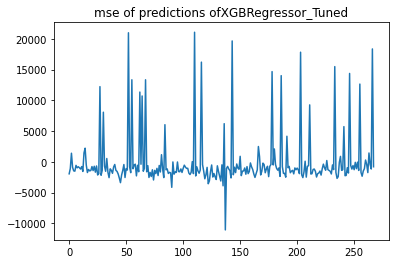

,model,rmse_mean,rmse_std,mae_mean,mae_std
0,LinearRegression,6155.112802,4.956161e+06,64.995007,265.229978
1,Lasso,6146.783657,5.028188e+06,65.126862,244.462377
2,Ridge,6146.993987,5.004419e+06,65.168117,243.363537
3,RandomForestRegressor,4887.590454,4.560856e+06,52.432015,175.509371
4,XGBRegressor,5334.370597,6.093790e+06,56.076843,304.273546
5,RandomForestRegressor_Tuned,4606.075065,4.614830e+06,51.092356,154.667537
6,XGBRegressor_Tuned,5095.931503,5.047257e+06,56.445104,218.065482
7,Sequential,4708.911689,4.903690e+06,52.020748,357.071024
8,XGBRegressor_Tuned,4561.955219,4.740726e+06,50.765572,154.377911
9,XGBRegressor_Tuned,4561.955219,4.740726e+06,50.765572,154.377911


In [220]:
model = grid_XGB.best_params_['model']

results_df = model_results(model, results_df, model_name = 'XGBRegressor_Tuned')
results_df

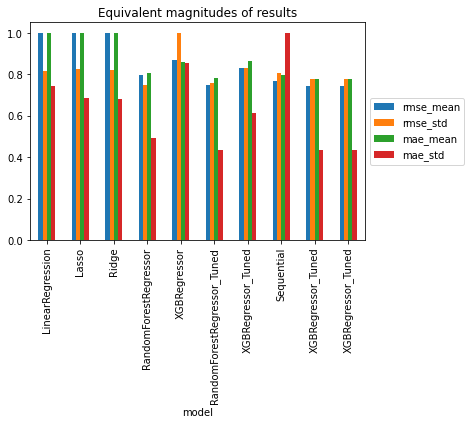

In [221]:
normalized_bar_plot(results_df)


In [ ]:
# model = XGBRegressor(
#     n_estimators=100,
#     reg_lambda=1,
#     gamma=0,
#     max_depth=3
# )

# Neural Networks

links:

    - [Examplefmodel](https://www.codespeedy.com/the-sequential-model-in-keras-in-python/)
    - [book of always](https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/)
    - [How to cross-validate a hole network](https://chrisalbon.com/code/deep_learning/keras/k-fold_cross-validating_neural_networks/)
    - [Good example of regression with NN](https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/)

In [109]:

# Regression Example With Boston Dataset: Standardized
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# define the model


# model = Sequential()
# model.add(Dense(1024, input_dim=len(ct.fit_transform(X_train)[0]), kernel_initializer='normal', activation='relu'))
# model.add(Dense(512, kernel_initializer='normal', activation='relu'))
# model.add(Dense(1, kernel_initializer='normal', activation='relu'))


ct = make_pipeline(column_trans,StandardScaler())

model = Sequential()
model.add(Dense(1024, input_dim=len(ct.fit_transform(X_train)[0]),  activation='relu'))
model.add(Dense(512,  activation='relu'))
model.add(Dense(1,  activation='relu'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# create the Pipeline
pipe = Pipeline([('preprocessor', ct), ('model', model)])

# pipe = make_pipeline(column_trans,StandardScaler(), model)
pipe.fit(X_train, y_train, model__epochs = 10, model__validation_split = 0.1, model__batch_size=10)
y_pred = pipe.predict(X_test)

mse_test_pred = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test_pred = mean_absolute_error(y_test, y_pred)
print("rmse test = ",mse_test_pred)
print("mae test = ",mae_test_pred)
plt.plot(np.array(y_test)-[i[0] for i in y_pred])
plt.show()

# RandomForestRegressor
# mean error= 21899438.30561661 std error= 4728131.56890985
# rmse test =  4679.683568962394
# mae test =  2433.500512512784

Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_484 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_485 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_486 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_487 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_488 (Dense)            (None, 1)                 65        
Total params: 18,177
Trainable params: 18,177
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
963/963 - 4s - loss: 6285.0327 - val_loss: 3322.1289
Epoch 2/80
963/963 - 1s - loss: 3350.0408 - val_lo

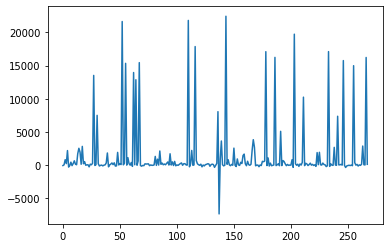

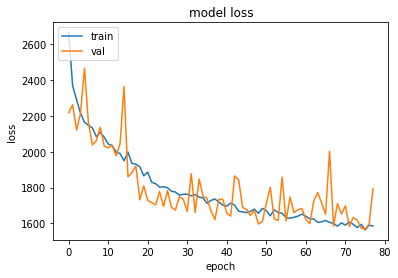

In [187]:

from keras.layers import Dropout
column_trans_NN = make_column_transformer(
    (OneHotEncoder(), ['sex', 'smoker', 'region']),
    (StandardScaler(), ['age', 'bmi', 'children']),
    remainder='passthrough')

X_train_ct = column_trans_NN.fit_transform(X_train)
X_test_ct = column_trans_NN.transform(X_test)

model = Sequential()
model.add(Dense(128, input_dim=len(column_trans_NN.fit_transform(X_train)[0]),  activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(64,  activation='relu'))
# model.add(Dropout(0.20))
# model.add(Dropout(0.20))
model.add(Dense(64,  activation='relu'))
model.add(Dense(64,  activation='relu'))
model.add(Dense(1,  activation='relu'))
# Compile model
# model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_absolute_error', optimizer='adam')

model.summary()
# create the Pipeline

# pipe = make_pipeline(column_trans,StandardScaler(), model)
history = model.fit(X_train_ct, y_train, epochs = 80, validation_split = 0.1, batch_size=1, verbose = 2)
y_pred = model.predict(X_test_ct)


mse_test_pred = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test_pred = mean_absolute_error(y_test, y_pred)
print("rmse test = ",mse_test_pred)
print("mae test = ",mae_test_pred)
plt.plot(np.array(y_test)-[i[0] for i in y_pred])
plt.show()

skip_to_plot = 2
plt.plot(history.history['loss'][skip_to_plot:])
plt.plot(history.history['val_loss'][skip_to_plot:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [81]:

from keras.wrappers.scikit_learn import KerasClassifier
# Wrap Keras model so it can be used by scikit-learn
neural_network = KerasClassifier(build_fn=model,
                                 epochs=10,
                                 batch_size=100,
                                 verbose=0)

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_276 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_277 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_278 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


TypeError: cross_val_score() got an unexpected keyword argument 'epochs'

In [193]:
# results_df_BEFORE_NN = results_df.copy()




In [210]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold

column_trans_NN = make_column_transformer(
    (OneHotEncoder(), ['sex', 'smoker', 'region']),
    (StandardScaler(), ['age', 'bmi', 'children']),
    remainder='passthrough')

X_train_ct = column_trans_NN.fit_transform(X_train)
X_test_ct = column_trans_NN.transform(X_test)


# Create function returning a compiled network
def create_network():
    model = Sequential()
    model.add(Dense(128, input_dim=len(column_trans_NN.fit_transform(X_train)[0]), activation='relu'))
    model.add(Dropout(0.10))
    model.add(Dense(64,  activation='relu'))
    # model.add(Dropout(0.20))
    # model.add(Dropout(0.20))
    model.add(Dense(64,   activation='relu'))
    model.add(Dense(1,  activation='relu'))
    # Compile model
    # model.compile(loss='mean_squared_error', optimizer='adam')
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Return compiled network
    return model



# evaluate model
model = KerasRegressor(build_fn=create_network, epochs=80, batch_size=1, verbose=0)

Sequential


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
2021-11-25 18:47:46.065250: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-25 18:47:46.067404: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-25 18:47:46.067603: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations: 

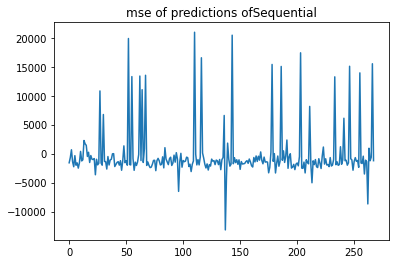

,model,rmse_mean,rmse_std,mae_mean,mae_std
0,LinearRegression,6155.112802,4.956161e+06,64.995007,265.229978
1,Lasso,6146.783657,5.028188e+06,65.126862,244.462377
2,Ridge,6146.993987,5.004419e+06,65.168117,243.363537
3,RandomForestRegressor,4887.590454,4.560856e+06,52.432015,175.509371
4,XGBRegressor,5334.370597,6.093790e+06,56.076843,304.273546
5,RandomForestRegressor_Tuned,4606.075065,4.614830e+06,51.092356,154.667537
6,XGBRegressor_Tuned,5095.931503,5.047257e+06,56.445104,218.065482
7,Sequential,4708.911689,4.903690e+06,52.020748,357.071024


In [211]:
results_df = results_df_BEFORE_NN.copy()
results_df = model_results(model, results_df, model_name = 'Sequential',verbose=3)
results_df


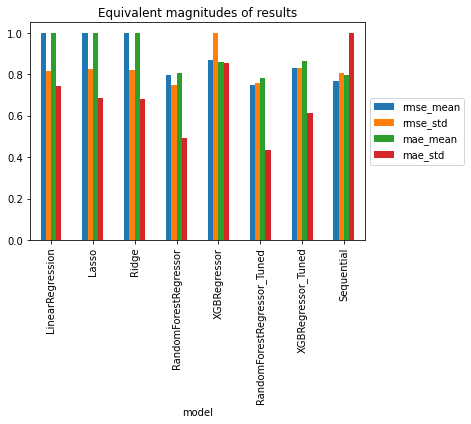

In [213]:
normalized_bar_plot(results_df)



In [212]:
print(results_df)

                         model    rmse_mean      rmse_std   mae_mean  \
0             LinearRegression  6155.112802  4.956161e+06  64.995007   
1                        Lasso  6146.783657  5.028188e+06  65.126862   
2                        Ridge  6146.993987  5.004419e+06  65.168117   
3        RandomForestRegressor  4887.590454  4.560856e+06  52.432015   
4                 XGBRegressor  5334.370597  6.093790e+06  56.076843   
5  RandomForestRegressor_Tuned  4606.075065  4.614830e+06  51.092356   
6           XGBRegressor_Tuned  5095.931503  5.047257e+06  56.445104   
7                   Sequential  4708.911689  4.903690e+06  52.020748   

      mae_std  
0  265.229978  
1  244.462377  
2  243.363537  
3  175.509371  
4  304.273546  
5  154.667537  
6  218.065482  
7  357.071024  


In [202]:

results_df = results_df.drop([7],axis=0)

In [181]:
results_df.drop([6,7],axis=0)


,model,rmse_mean,rmse_std,mae_mean,mae_std
0,LinearRegression,6158.971103,7.110710e+06,64.567304,406.521114
1,Lasso,6132.741975,6.538855e+06,65.083060,373.097415
2,Ridge,6133.084193,6.510691e+06,65.120572,372.159798
3,RandomForestRegressor,4930.656739,4.602699e+06,52.934178,193.439769
4,XGBRegressor,5391.772806,4.793278e+06,56.658149,228.313632


In [206]:
results_df_BEFORE_NN


,model,rmse_mean,rmse_std,mae_mean,mae_std
0,LinearRegression,6155.112802,4.956161e+06,64.995007,265.229978
1,Lasso,6146.783657,5.028188e+06,65.126862,244.462377
2,Ridge,6146.993987,5.004419e+06,65.168117,243.363537
3,RandomForestRegressor,4887.590454,4.560856e+06,52.432015,175.509371
4,XGBRegressor,5334.370597,6.093790e+06,56.076843,304.273546
5,RandomForestRegressor_Tuned,4606.075065,4.614830e+06,51.092356,154.667537
6,XGBRegressor_Tuned,5095.931503,5.047257e+06,56.445104,218.065482


In [ ]:



skip_to_plot = 20
plt.plot(history.history['loss'][skip_to_plot:])
plt.plot(history.history['val_loss'][skip_to_plot:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.xlim([skip_to_plot,8])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:


y_test

In [ ]:

# ct = make_column_transformer(column_trans, StandardScaler())


column_trans_NN = make_column_transformer(
    (OneHotEncoder(), ['sex', 'smoker', 'region']),
    (StandardScaler(), ['age', 'bmi', 'children']),
    remainder='passthrough')


column_trans_NN.fit_transform(X_train)
column_trans_NN.transform(X_train)



In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import scipy as sp # to simulate uniform(0,1)
import time 

# dummy encoding of categorical features
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

# use when different features need different preprocessing
from sklearn.compose import make_column_transformer

# chain sequential steps together
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score

# from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import xgboost as xgb


from sklearn.preprocessing import PolynomialFeatures

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
column_trans = make_column_transformer(
    (OneHotEncoder(), ['sex', 'smoker', 'region']),
    (StandardScaler(), ['age', 'bmi', 'children']),
    remainder='passthrough')

models = [LinearRegression(), Lasso(), Ridge(), RandomForestRegressor(), XGBRegressor()]

col_results = ['model', 'rmse', 'mae', 'std_neg_mse']

results_df = pd.DataFrame(np.zeros([len(models),len(col_results)]), columns=col_results)

for i, model in enumerate(models):
    model_name = type(model).__name__
    print(model_name)
    pipe = make_pipeline(column_trans, model)
    c_scores = cross_val_score(pipe, X_train, y_train, cv=10,scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'][1])
    print("CV mean mse=",-c_scores.mean(), "CV std mse=",c_scores.std())
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mse_test_pred = np.sqrt(-c_scores.mean()) # before np.sqrt(mean_squared_error(y_test, y_pred))
    mae_test_pred = mean_absolute_error(y_test, y_pred)
#     print("rmse test = ",mse_test_pred)
#     print("mae test = ",mae_test_pred)
    plt.plot(np.array(y_test)-y_pred)
    plt.show()
    results_df.iloc[i] = [model_name, mse_test_pred, mae_test_pred, c_scores.std()]
    
# plotting graph
results_df.plot(x="model", y=["rmse", "mae"], kind="bar")
plt.ylim([0,7000])
plt.show()
results_df.plot(x="model", y=["std_neg_mse"], kind="bar")
plt.show()

results_df

TODO:

- Try tunining using pipeline [link](https://github.com/justmarkham/scikit-learn-tips/blob/master/notebooks/49_tune_multiple_models.ipynb)
- Kaggle version of data [Link](https://www.kaggle.com/mirichoi0218/insurance)

In [ ]:
from keras.layers import Dropout
column_trans_NN = make_column_transformer(
    (OneHotEncoder(), ['sex', 'smoker', 'region']),
    (StandardScaler(), ['age', 'bmi', 'children']),
    remainder='passthrough')


X_train_ct = column_trans_NN.fit_transform(X_train)
X_test_ct = column_trans_NN.transform(X_test)

model = Sequential()
model.add(Dense(32, input_dim=len(ct.fit_transform(X_train)[0]),  activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(32,  activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(32,  activation='relu'))
model.add(Dense(32,  activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(32,  activation='relu'))
model.add(Dense(1,  activation='relu'))
# Compile model
# model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_absolute_error', optimizer='adam')

model.summary()
# create the Pipeline

# pipe = make_pipeline(column_trans,StandardScaler(), model)
history = model.fit(X_train_ct, y_train, epochs = 100, validation_split = 0.1, batch_size=5, verbose = 2)
y_pred = model.predict(X_test_ct)


mse_test_pred = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test_pred = mean_absolute_error(y_test, y_pred)
print("rmse test = ",mse_test_pred)
print("mae test = ",mae_test_pred)
plt.plot(np.array(y_test)-[i[0] for i in y_pred])
plt.show()

skip_to_plot = 2
plt.plot(history.history['loss'][skip_to_plot:])
plt.plot(history.history['val_loss'][skip_to_plot:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



INTRODUCTION
1.Cover page followed by the title, names of authors, their affiliations, and contacts, name of the institutional publisher (if any), and the date of publication
2. Table of contents(ToC) contains a list of topics sub-topics, charts, graph and other pictorial information used in the report.
3. Abstract or summary of the report.
4. Introductory section which contains gently introduced to the subject matter and written in easily understandable formate.
BODY OF REPORT
5. Data Section: Include written descriptions of data and follow with relevant spreadsheets or variables in the data source.
6. Methodology Section — Contains research methods and data sources used in the report.
7. Analysis Section — Explain what we analyzed. Include any charts here.
8. Result Section followed by a discussion section. Describe the results of your analysis in the result section. The discussion section is where you rely on the power of narrative to enable numbers to communicate the thesis to your readers.
CONCLUSION
9. Conclusion Section: Concluding the overall report, outcomes of the report, application of the research in future.
10.References and acknowledgement section. Appendix is optional